## __LSTM IMPLEMENTATION__<hr>

### Import Libraries<hr>
We will use *pandas* and *numpy* for data manipulation, *nltk* for NLP, *matplotlib*, *seaborn*, and *plotly* for data visualization, *sklearn* and *keras* for training the model.

In [96]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline

### Load the dataset<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments).

In [97]:
twitter = pd.read_csv('../data/twitter.csv', usecols=[3,4])
facebook = pd.read_csv('../data/facebook.csv', usecols=[3,4])
df = pd.concat([twitter, facebook])
df.head()

,Clean_Translated,Tag
0,Hahahahahhaha happiest day of my life. You hav...,1
1,I like the chocolate bars and then you are thi...,0
2,Hey. You're cute,0
3,I save on going to the massage spa because I h...,0
4,Pretending we know things,0


### Data Analysis - Statistics
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

In [98]:
print(df.shape)
print(facebook.shape)
print(twitter.shape)

(1001, 2)
(501, 2)
(500, 2)


we check for missing values using __isna()__:

In [99]:
# No missing values
twitter[twitter.isna().any(axis=1)]
facebook[facebook.isna().any(axis=1)]
df[df.isna().any(axis=1)]

,Clean_Translated,Tag


### Statistic<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments).

length of all sentences in dataset and statistic:

In [100]:
lens = df['Clean_Translated'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

58.73326673326673 42.09279964813201 6 269


Distribution of tweets and post length:

In [101]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

Correlate length and sentiment marks:

In [102]:
df['Text_Length'] = df['Clean_Translated'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

Pearson correlation:

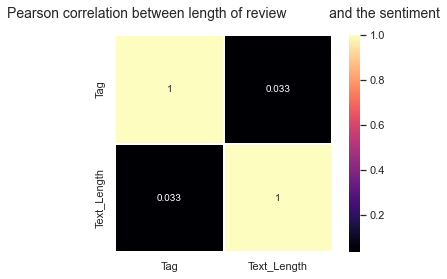

In [103]:
colormap = plt.cm.magma
plt.title('Pearson correlation between length of review\
           and the sentiment', y=1.05, size=14)
sns.heatmap(data.drop(['Clean_Translated'], axis=1).astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

#### Commonly seen words in one tag:

In [104]:
df_neg = df[ df['Tag'] == 1]
df_neg = df_neg['Clean_Translated']
df_pos = df[ df['Tag'] == 0]
df_pos = df_pos['Clean_Translated']

>Commonly seen in "__Negative__" sentences

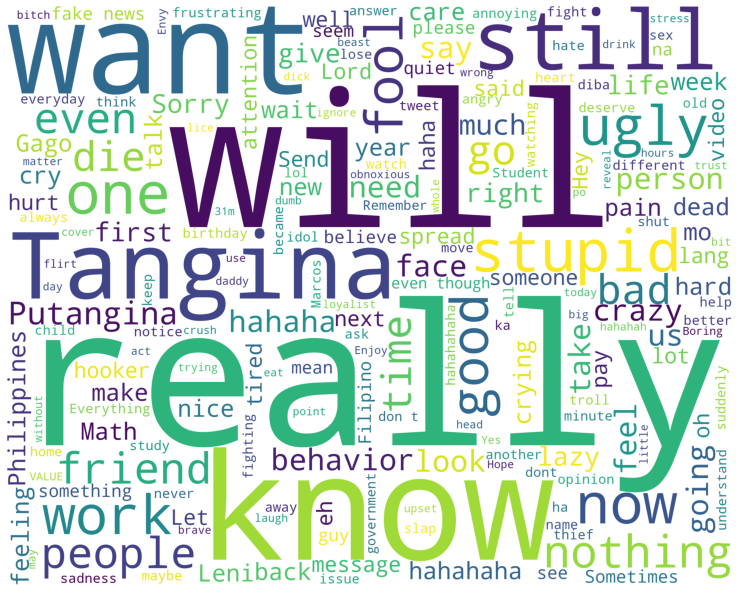

In [105]:
wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

>Commonly seen in "__Positive__" sentences

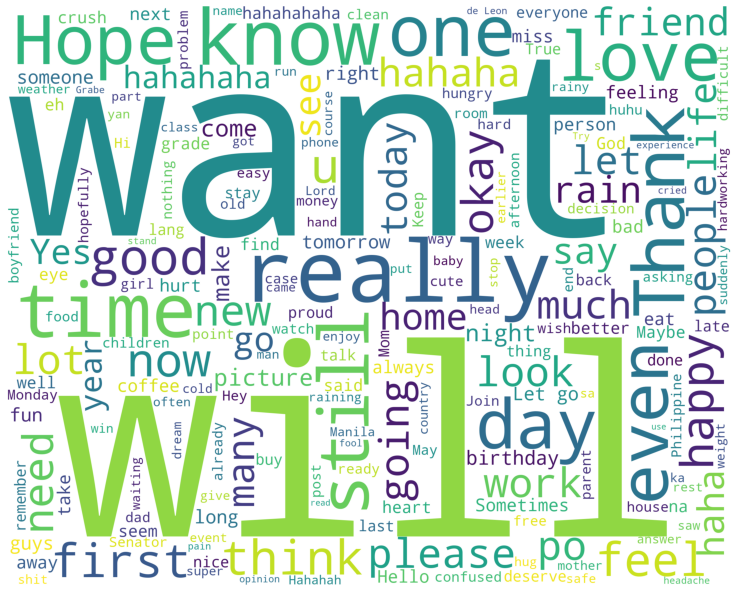

In [106]:
wordcloud2 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(2,figsize=(13, 13))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

#### Distribution of Sentiments:
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

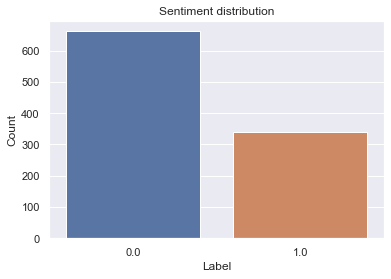

In [107]:
sns.set(style="darkgrid")
b = sns.countplot(x='Tag',
                  data = df.drop(['Clean_Translated'], axis=1).astype(float))
b.axes.set_title('Sentiment distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

### Text Preprocessing<hr>
Cleaning the text to remove punctuations, transform to lower case, remove emojis, remove hashtags, remove tags, and remove links:

In [112]:
df['Clean_Translated'] = df['Clean_Translated'].apply(prep.simplify_text)
df.head()

,Clean_Translated,Tag,Text_Length
0,Hahahahahhaha happiest day of my life You have...,1,187
1,I like the chocolate bars and then you are thi...,0,94
2,Hey Youre cute,0,16
3,I save on going to the massage spa because I h...,0,93
4,Pretending we know things,0,25


Split for training and testing:

In [109]:
text = df['Clean_Translated']
tag = df['Tag']
text_train, text_test, tag_train, tag_test = train_test_split(text, tag, test_size=0.1)

### Training the Model<hr>
We use parameter $\text{min}_{\text{df}} = 2$ to filter out words that occur only once in the entire dataset.

In [110]:
vectorizer = TfidfVectorizer(min_df=2)
train_term = vectorizer.fit_transform(text_train)
test_term = vectorizer.transform(text_test)

Check words that will be used by the models as features:

In [130]:
vectorizer.get_feature_names()[:20]

['10',
 '1st',
 '2022',
 '31m',
 '333',
 '40',
 'able',
 'about',
 'acads',
 'acclaimed',
 'according',
 'account',
 'aches',
 'achieve',
 'act',
 'active',
 'activity',
 'add',
 'admits',
 'after']